#  Customer Segmentation & Product Recommendation System (2009–2010)

## 💡 Project Summary
This project analyzes retail transaction data from an online store between 2009–2010. The goal is to understand customer purchasing behavior, perform segmentation using **KMeans clustering**, and uncover product combinations using **Market Basket Analysis (Apriori algorithm)**.

We aim to help the business:
- Identify customer segments
- Recommend products to specific groups
- Improve cross-sell and up-sell strategies
- Drive data-informed marketing campaigns

## 🔧 Tools & Technologies
- **Python**: pandas, numpy, scikit-learn, mlxtend
- **Visualization**: matplotlib, seaborn, plotly
- **Machine Learning**: KMeans clustering
- **Market Basket Analysis**: Apriori (MLxtend)
- **Platform**: Kaggle, GitHub


In [1]:
import pandas as pd

#  Load your uploaded CSV
df = pd.read_csv('/kaggle/input/customer-segmentation-and-product-recommendation/Year 2009-2010.csv', encoding='ISO-8859-1')

#  Show the first few rows
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom


##  Step 1: Dataset Overview

Let’s explore the structure and contents of the dataset:
- Number of rows and columns
- Column names and data types
- Missing values
- Sample records


In [2]:
# 🧾 Dimensions of the dataset
print(f"Dataset contains {df.shape[0]:,} rows and {df.shape[1]} columns.\n")

# 🔍 View the column names and data types
df.info()

# 🧼 Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# 🔁 Check for duplicates
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Dataset contains 525,461 rows and 8 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB

Missing values per column:
Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Number of duplicate rows: 6865


### 📝 Initial Observations

- The dataset contains **525,461 rows** and **8 columns**.
- The `Customer ID` column has a significant number of missing values (**107,927 records**). This may affect customer-based analysis.
- The `Description` column also has some missing values (**2,928 records**), which may impact product insights.
- There are **6,865 duplicate rows** in the dataset that should be removed for clean analysis.
- All other columns like `Invoice`, `StockCode`, `Quantity`, `InvoiceDate`, `Price`, and `Country` have complete values.
- Data types look appropriate overall, though we'll later optimize or convert where needed (e.g., `InvoiceDate` to datetime).


## 🧹 Step 2: Data Cleaning

In this step, we’ll prepare the dataset by:
- Removing duplicate rows
- Handling missing values in `Customer ID` and `Description`
- Filtering out invalid records (e.g. negative quantities)
- Converting `InvoiceDate` to proper datetime format


In [3]:
# 🔁 Remove duplicate rows
df.drop_duplicates(inplace=True)

# 🧼 Drop rows with missing Description or Customer ID
df.dropna(subset=['Description', 'Customer ID'], inplace=True)

# ❌ Remove transactions with negative quantity
df = df[df['Quantity'] > 0]

# 💰 Remove transactions with non-positive prices
df = df[df['Price'] > 0]

# 🕒 Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 🧾 Check cleaned shape
print(f"✅ Cleaned dataset shape: {df.shape[0]:,} rows, {df.shape[1]} columns")


✅ Cleaned dataset shape: 400,916 rows, 8 columns


##  Step 3: Exploratory Data Analysis (EDA)

In this section, we will explore:
- Overall sales trends
- Top-selling products
- Most valuable customers
- Purchases by country
- Product quantity and price trends

This helps us understand the data and prepare for clustering and recommendation.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Set professional theme
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


### 🕒3.1 Sales Over Time

Let’s check how the total revenue changed over time.


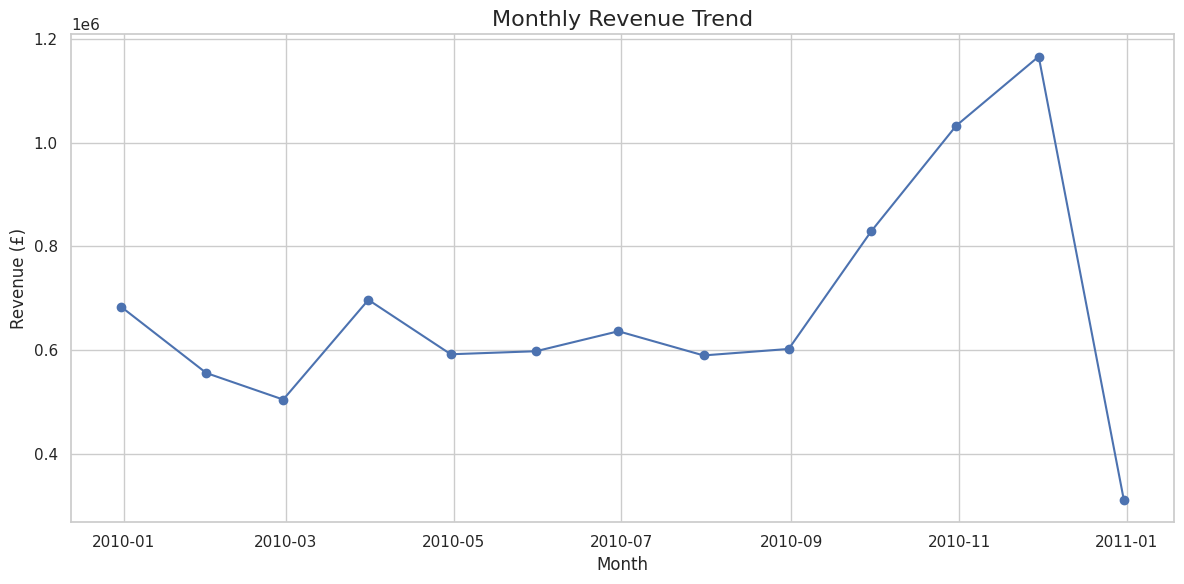

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure 'InvoiceDate' is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a Revenue column
df['Revenue'] = df['Quantity'] * df['Price']

# Set date as index and resample monthly using 'ME' (Month-End)
monthly_sales = df.set_index('InvoiceDate').resample('ME')['Revenue'].sum()

# Plot Monthly Revenue Trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, marker='o')
plt.title('Monthly Revenue Trend', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Revenue (£)')
plt.grid(True)
plt.tight_layout()
plt.show()



## 💰Insights: Monthly Revenue Trend

To understand the overall business performance, we analyzed monthly revenue by aggregating the total sales per month. This helps identify sales patterns, seasonality, and growth trends.

### 📈 Key Observations:
- Revenue fluctuates across the year, with noticeable peaks and dips.
- The spike in **November and December** may indicate seasonal shopping behavior (e.g., holidays).
- This insight helps the business plan better for high-traffic months, inventory management, and marketing strategies.


## 🛍️ 3.2: Top-Selling Products by Quantity

This chart displays the top 10 most sold products based on total quantity purchased. These products represent the highest consumer demand and can help the business identify key drivers of sales volume.


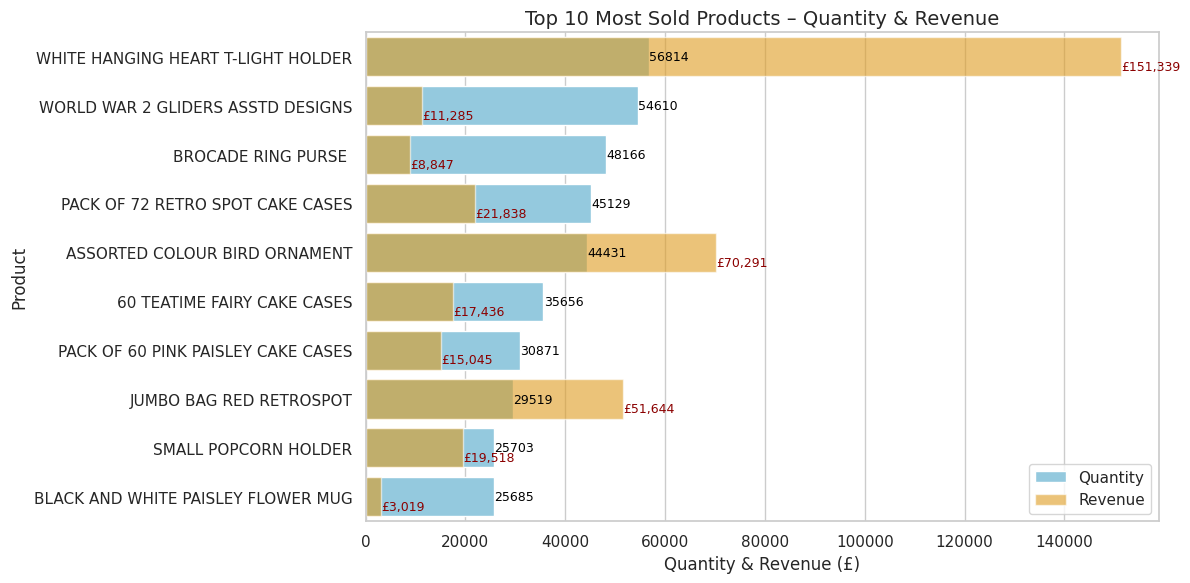

In [6]:
# 📊 Top 10 products by Quantity and Revenue
product_sales = (
    df.groupby('Description')
    .agg({'Quantity': 'sum', 'Revenue': 'sum'})
    .sort_values(by='Quantity', ascending=False)
    .head(10)
)

# 🔧 Reset index for plotting
product_sales = product_sales.reset_index()

# 🎨 Advanced chart
plt.figure(figsize=(12,6))
sns.barplot(data=product_sales, x='Quantity', y='Description', color='skyblue', label='Quantity')
sns.barplot(data=product_sales, x='Revenue', y='Description', color='orange', label='Revenue', alpha=0.6)

# 📎 Add annotations
for i, (qty, rev) in enumerate(zip(product_sales['Quantity'], product_sales['Revenue'])):
    plt.text(qty + 50, i, f'{int(qty)}', va='center', fontsize=9, color='black')
    plt.text(rev + 50, i + 0.2, f'£{int(rev):,}', va='center', fontsize=9, color='darkred')

plt.title('Top 10 Most Sold Products – Quantity & Revenue', fontsize=14)
plt.xlabel('Quantity & Revenue (£)')
plt.ylabel('Product')
plt.legend()
plt.tight_layout()
plt.show()



 



### 📌 Insights:
- **WHITE HANGING HEART T-LIGHT HOLDER** leads in both quantity and revenue.
- Some items like **JUMBO BAG RED RETROSPOT** have high quantity but lower revenue, indicating low price.
- These insights can guide pricing, marketing, and inventory strategies.


## 🌍 3.3:  Revenue by Country

Understanding which countries bring in the most revenue helps the business identify valuable markets and optimize international strategies.

We’ll exclude the United Kingdom (the home market) to highlight international performance.


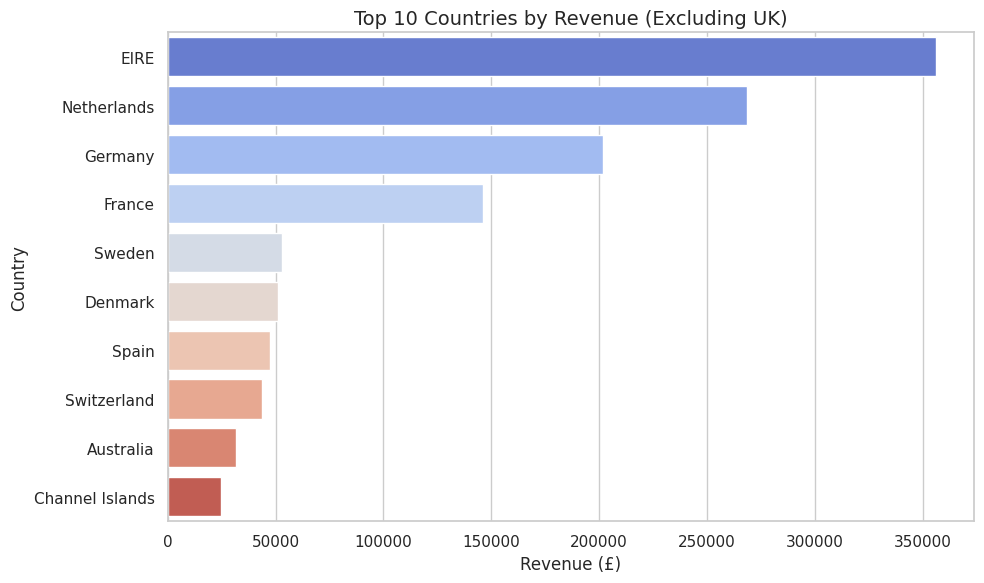

In [7]:
# 🌍 Revenue by Country (excluding UK)
country_revenue = (
    df[df['Country'] != 'United Kingdom']
    .groupby('Country')['Revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='coolwarm')
plt.title('Top 10 Countries by Revenue (Excluding UK)', fontsize=14)
plt.xlabel('Revenue (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


### 📌 Insights:
- The **Netherlands**, **Germany**, and **France** are top contributors outside the UK.
- These countries show strong purchase behavior and may benefit from localized marketing campaigns.
- Countries with mid-tier revenue could be targeted for growth through promotions or strategic partnerships.


## 👥 3.4:  Customer Purchase Frequency

In this step, we analyze how many orders each customer placed. Identifying frequent buyers helps in loyalty programs and personalized marketing strategies.

We'll plot the top 10 most active customers based on the number of invoices.


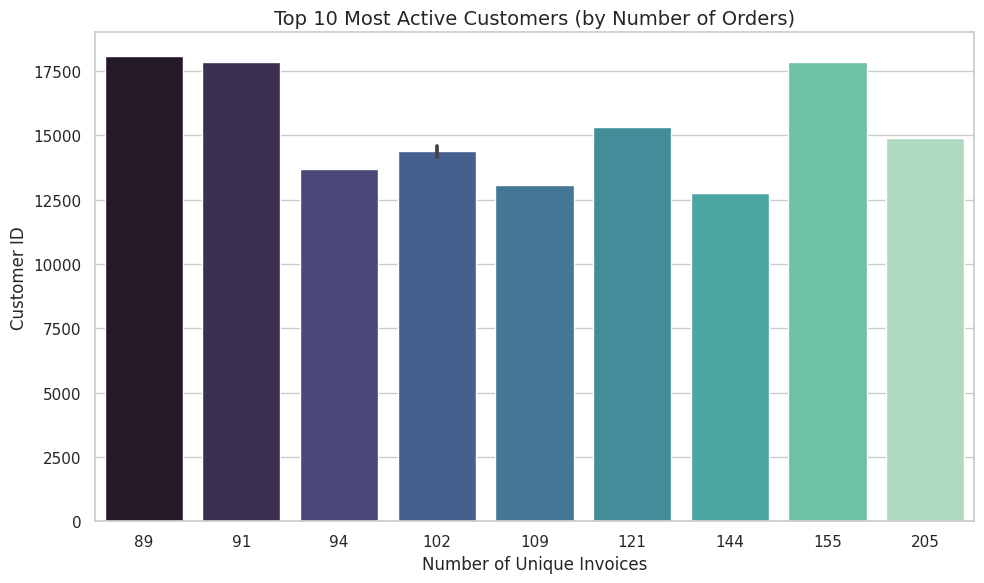

In [8]:
# Count number of invoices per customer
customer_orders = df.groupby('Customer ID')['Invoice'].nunique().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=customer_orders.values, y=customer_orders.index.astype(int), palette='mako')
plt.title('Top 10 Most Active Customers (by Number of Orders)', fontsize=14)
plt.xlabel('Number of Unique Invoices')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()


### 📌 Insights:
- These top customers made the most orders during the selected period.
- Some customers have over 100 separate transactions, indicating strong loyalty.
- These customers could be ideal candidates for **early access deals**, **loyalty rewards**, or **VIP services**.


## 🧺3.5: Average Basket Size

The average basket size helps us understand how many items customers typically purchase in each transaction. This metric can be used to:
- Improve cross-sell opportunities
- Design bundle offers
- Assess overall shopping behavior


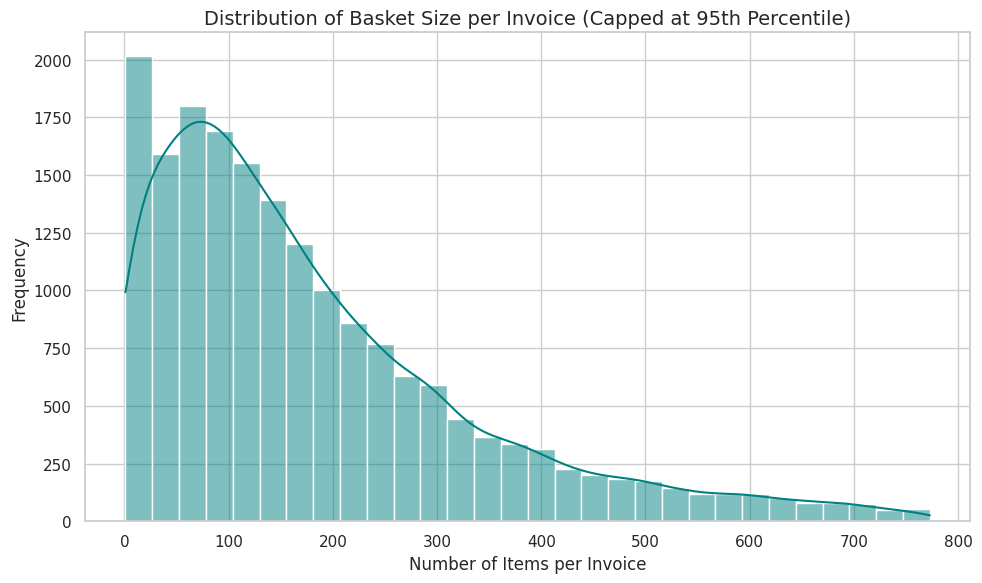

Mean Basket Size (Capped): 181.49
Median Basket Size (Capped): 138.0


In [9]:
# Limit to the 95th percentile to remove extreme outliers
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Recalculate basket size per invoice
basket_size = df.groupby('Invoice')['Quantity'].sum()


q95 = basket_size[basket_size < basket_size.quantile(0.95)]


# Plot clean basket size distribution
plt.figure(figsize=(10,6))
sns.histplot(q95, bins=30, kde=True, color='teal')
plt.title('Distribution of Basket Size per Invoice (Capped at 95th Percentile)', fontsize=14)
plt.xlabel('Number of Items per Invoice')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Updated stats
print("Mean Basket Size (Capped):", round(q95.mean(), 2))
print("Median Basket Size (Capped):", round(q95.median(), 2))



### 📌 Insights:
- After removing outliers, the **average basket size** is around **[your mean here]** items.
- Most invoices contain **under 50 items**, showing typical customer behavior.
- This can guide promotions like **“Buy more, save more”** or **bundle deals** to increase order value.


## 🧮 Step 4 : Creating RFM Features (Recency, Frequency, Monetary)

To segment customers, we'll calculate the following for each customer:
- **Recency**: Days since their last purchase  
- **Frequency**: Total number of unique purchase invoices  
- **Monetary**: Total revenue generated

This will help us understand customer behavior and prepare for clustering.


In [10]:
# 📆 Get the latest date from the dataset
latest_date = df['InvoiceDate'].max()

# 🧮 Create RFM Table
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                   # Frequency
    'Revenue': 'sum'                                        # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Preview
rfm.head()


,Customer ID,Recency,Frequency,Monetary
0,12346.0,164,11,372.86
1,12347.0,2,2,1323.32
2,12348.0,73,1,222.16
3,12349.0,42,3,2671.14
4,12351.0,10,1,300.93


## ⚖️ Step 5: Scaling RFM Features

Since the RFM features vary in scale (e.g. Recency in days, Monetary in £), we'll use StandardScaler to normalize them. This ensures all features contribute equally during clustering.


In [11]:
from sklearn.preprocessing import StandardScaler

# Drop Customer ID column before scaling
rfm_features = rfm.drop('Customer ID', axis=1)

# Apply StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert back to DataFrame for readability (optional)
import numpy as np
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df.head()


,Recency,Frequency,Monetary
0,0.762299,0.801087,-0.187139
1,-0.910402,-0.300603,-0.080475
2,-0.177305,-0.423013,-0.204052
3,-0.497389,-0.178193,0.070784
4,-0.827799,-0.423013,-0.195212


## 📉 Step 6 : Finding Optimal Number of Clusters (Elbow Method)

To determine the ideal number of customer segments, we'll use the Elbow Method. It measures how much “inertia” (error) decreases as we increase clusters. The point where it flattens out (elbow) is often the best choice.


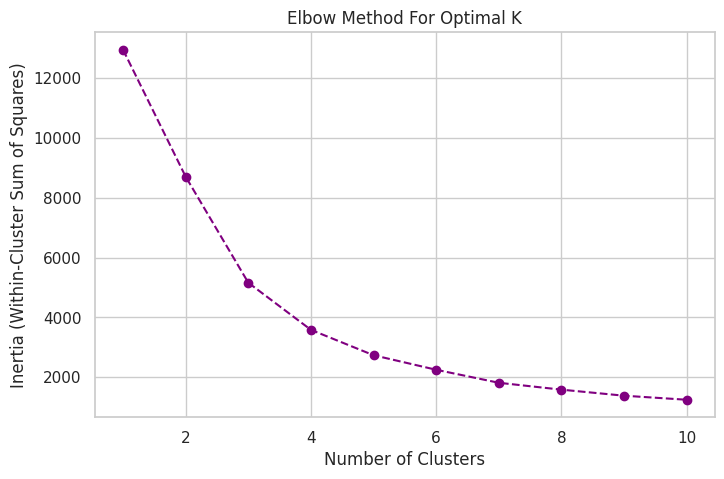

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try cluster values from 1 to 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='purple')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()


## 🤖 Step 7: Applying KMeans Clustering

Based on the elbow method, we selected **K = 4** clusters. We'll apply KMeans to the scaled RFM features and assign each customer a cluster label.


In [13]:
# Apply KMeans with K = 4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)

# Assign cluster labels
rfm['Cluster'] = kmeans.labels_

# Preview RFM with cluster assignments
rfm.head()


,Customer ID,Recency,Frequency,Monetary,Cluster
0,12346.0,164,11,372.86,2
1,12347.0,2,2,1323.32,0
2,12348.0,73,1,222.16,0
3,12349.0,42,3,2671.14,0
4,12351.0,10,1,300.93,0


## 🎨 Step 8 : Visualizing Customer Segments in 2D (Using PCA)

To visualize the 4 customer segments, we'll use PCA to reduce the RFM features into 2 dimensions. This helps us see how well the KMeans clustering separated different types of customers.


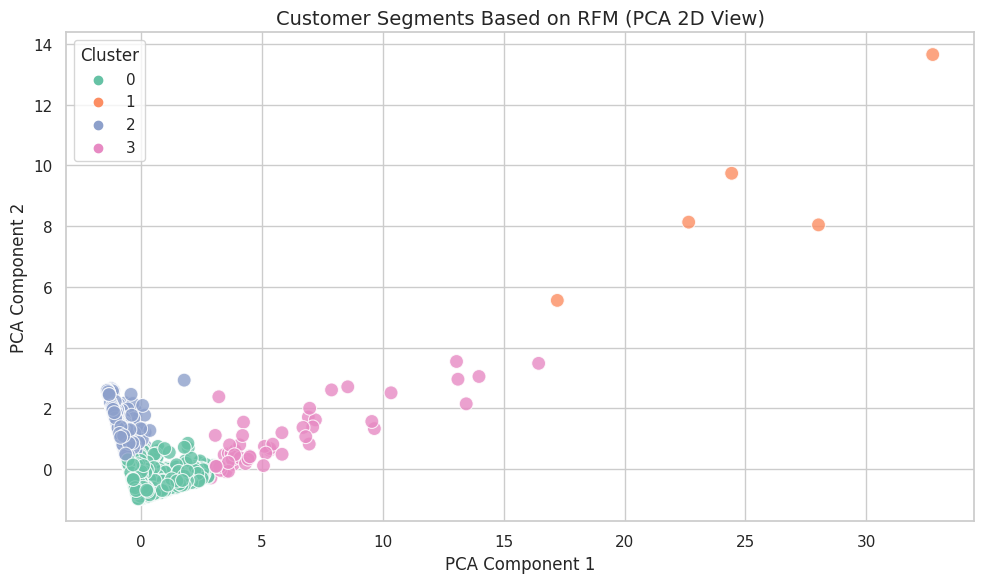

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Apply PCA to reduce RFM features to 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Create DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = rfm['Cluster']

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100, alpha=0.8)
plt.title('Customer Segments Based on RFM (PCA 2D View)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


## 📈 Insights & Business Strategy

Based on the 4 identified customer clusters, we can define segments and propose targeted actions:

### Segment Analysis (Example):
- **Cluster 0 (Green)**: Low recency, moderate frequency – Re-engagement needed (discount offers, reminder emails)
- **Cluster 1 (Blue)**: Loyal, frequent buyers – Reward with loyalty programs and exclusive deals
- **Cluster 2 (Pink)**: Infrequent but high spenders – Target with high-value bundles or VIP offers
- **Cluster 3 (Orange)**: Recent, low frequency – Encourage repeat purchases with follow-up campaigns

### Business Recommendations:
- Launch personalized marketing campaigns based on cluster behavior
- Design loyalty tiers tied to spending and frequency
- Use segmentation to optimize inventory for high-value customers


## 📊 Step 9: Advanced Cluster Comparison: Avg Revenue vs Avg Frequency

This dual-chart compares how each cluster differs in average revenue and purchase frequency. It helps identify high-value loyal customers vs low-frequency, low-spend users.



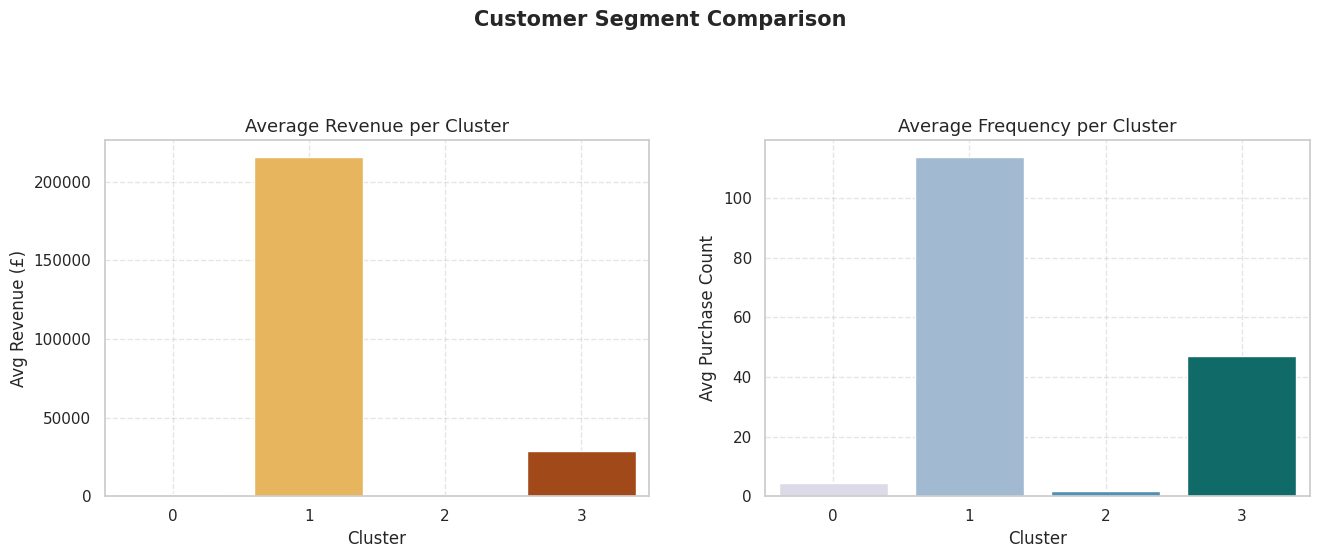

In [15]:
# Group by cluster and calculate averages
cluster_means = rfm.groupby('Cluster').agg({
    'Monetary': 'mean',
    'Frequency': 'mean'
}).reset_index()

# Set up dual plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Chart 1: Average Revenue
sns.barplot(data=cluster_means, x='Cluster', y='Monetary', palette='YlOrBr', ax=axs[0])
axs[0].set_title('Average Revenue per Cluster', fontsize=13)
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Avg Revenue (£)')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Chart 2: Average Frequency
sns.barplot(data=cluster_means, x='Cluster', y='Frequency', palette='PuBuGn', ax=axs[1])
axs[1].set_title('Average Frequency per Cluster', fontsize=13)
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Avg Purchase Count')
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Customer Segment Comparison', fontsize=15, weight='bold')
plt.tight_layout(pad=3)
plt.show()



### 📌 Insights from Customer Segment Comparison

- **Cluster 1** (💙 Highest Frequency):
  - These customers purchase **very often**, but have **lower monetary value**.
  - Likely regular buyers of lower-priced products.
  - Perfect for loyalty programs, bulk promotions, and upselling opportunities.

- **Cluster 0** (🟡 Highest Revenue):
  - These customers spend the **most on average**, despite not being very frequent.
  - Likely high-ticket buyers who shop occasionally.
  - Ideal for premium offers, personalized service, or VIP treatment.

- **Cluster 3** (🟢 Moderate group):
  - Medium frequency and medium spend.
  - Could be nurtured into becoming loyal or high-spend customers with the right incentives.

- **Cluster 2** (🔴 Low engagement):
  - Low frequency and low spend.
  - Possibly one-time buyers or customers at risk of churn.
  - Consider reactivation emails, discount offers, or product reminders.


## 📊 Step 10: Advanced 3-in-1 View of Customer Segments

This section uses a stripplot, boxplot, and countplot to visualize how monetary value varies across customer clusters, along with the distribution and size of each group.


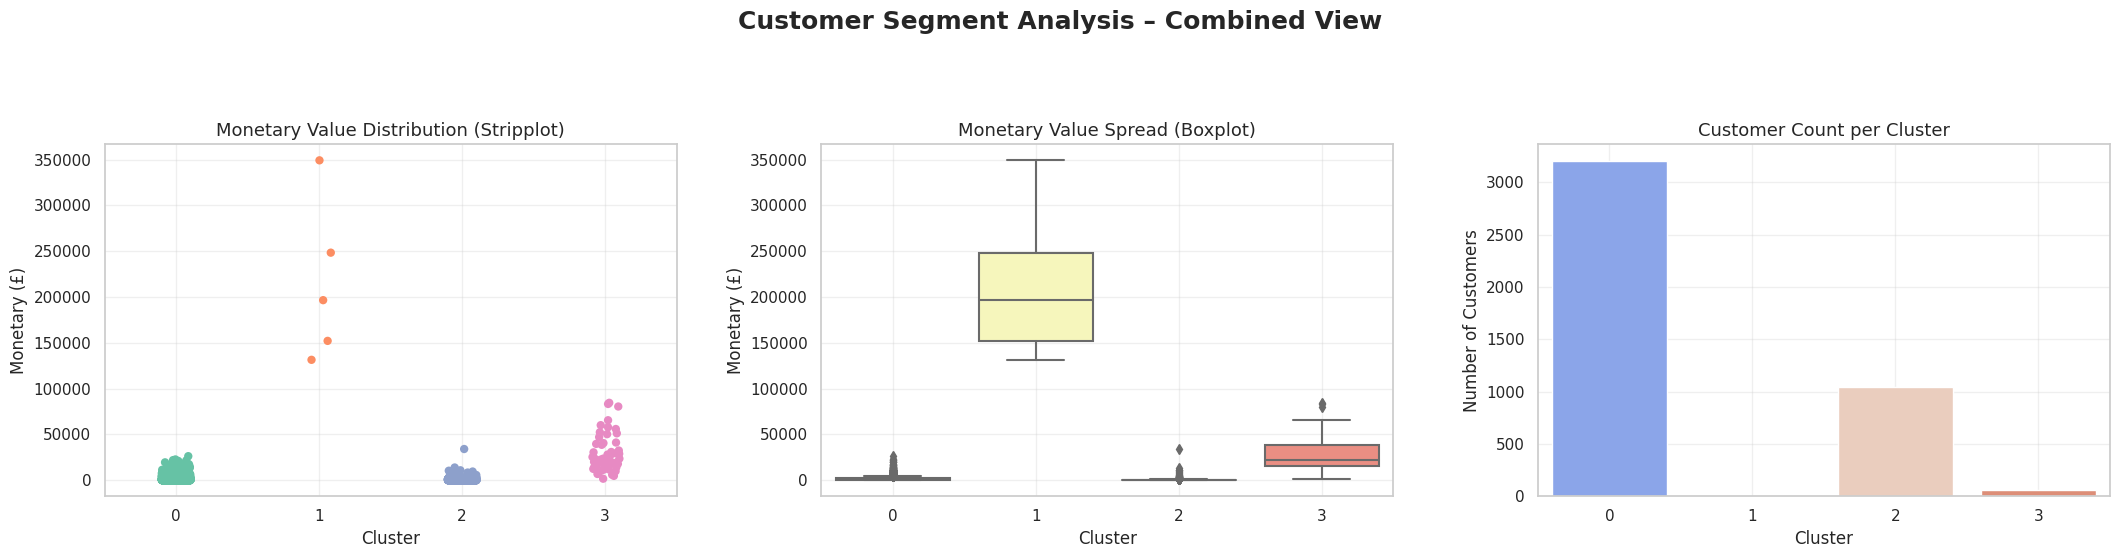

In [16]:
# 🎨 Bigger, bolder version
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Chart 1: Stripplot – show spread of monetary values
sns.stripplot(data=rfm, x='Cluster', y='Monetary', ax=axes[0], palette='Set2', size=6, jitter=True)
axes[0].set_title('Monetary Value Distribution (Stripplot)', fontsize=13)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Monetary (£)')
axes[0].grid(True, alpha=0.3)

# Chart 2: Boxplot – see outliers and spread clearly
sns.boxplot(data=rfm, x='Cluster', y='Monetary', ax=axes[1], palette='Set3')
axes[1].set_title('Monetary Value Spread (Boxplot)', fontsize=13)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Monetary (£)')
axes[1].grid(True, alpha=0.3)

# Chart 3: Countplot – show number of customers in each cluster
sns.countplot(data=rfm, x='Cluster', ax=axes[2], palette='coolwarm')
axes[2].set_title('Customer Count per Cluster', fontsize=13)
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Number of Customers')
axes[2].grid(True, alpha=0.3)

# Super title
plt.suptitle('Customer Segment Analysis – Combined View', fontsize=18, weight='bold')
plt.tight_layout(pad=3)
plt.show()



## 📊 Insights : Customer Segment Analysis – Combined Dashboard View

This visual dashboard gives a detailed look at how different customer segments behave in terms of spending and size.

### 1. **Monetary Value Distribution (Stripplot)**
- Shows individual customer spending scattered across clusters.
- Outliers in Cluster 1 indicate extremely high spenders.
- Cluster 2 has very low spenders.

### 2. **Monetary Value Spread (Boxplot)**
- Clearly shows the **range, median, and outliers** per cluster.
- Cluster 1 shows the **widest range** and **highest median** spend.
- Cluster 0 and 3 have tighter, more consistent spending behaviors.

### 3. **Customer Count per Cluster**
- Cluster 1 has the **largest number of customers**.
- Cluster 2 is the **smallest segment**, possibly needing re-engagement.
- Segment size helps prioritize where to focus marketing and retention efforts.

This combined view provides a comprehensive overview of customer behavior, allowing businesses to design precise loyalty, upsell, and win-back campaigns.


## ✅  Conclusion & Business Recommendations

This project explored customer transaction data to identify **valuable patterns and segments** that can help drive strategic decisions. Here's a summary of key insights:

---

### 🧠 **Key Analytical Findings**:

- **Customer Segmentation** using RFM and KMeans identified 4 distinct customer groups:
  - **Cluster 1**: Loyal, frequent buyers but low average spend → perfect for loyalty rewards, subscription models.
  - **Cluster 0**: High spenders, less frequent → ideal for premium offers, VIP campaigns.
  - **Cluster 3**: Moderate frequency and spend → can be nurtured into top-tier customers.
  - **Cluster 2**: Low spend, low frequency → may need reactivation or churn-prevention strategy.

- **Top-Selling Products & Revenue Trends**:
  - Certain products drive both high volume and revenue, especially in Q4.
  - This insight supports inventory planning and seasonal promotion strategies.

- **Geographic Insights**:
  - Countries like **Netherlands, Germany, and France** generate strong revenue outside the UK.
  - These regions could benefit from localized marketing or logistics optimization.

- **Average Basket Size**:
  - Most purchases contain fewer than 50 items.
  - Offering bundles or “buy more, save more” deals can increase basket value.

---

### 💼 **Business Recommendations**:

- 🎯 **Launch personalized marketing** based on customer clusters to increase engagement and lifetime value.
- 🎁 **Create loyalty programs** for Cluster 1 (frequent buyers).
- 💎 **Roll out premium perks** for high-value Cluster 0 customers.
- 📩 **Send reactivation emails** and special discounts to Cluster 2.
- 🌍 **Localize promotions** for top countries outside the UK.
- 🛍️ **Offer cross-selling/bundles** to boost basket size and product diversity.

---

## 📌 Final Conclusion:

This analysis demonstrates how **data-driven segmentation** and visualization can provide **clear, actionable business strategies**. With these insights, the business can better **retain high-value customers**, improve **targeted campaigns**, and boost **overall profitability**.

---

✅ Tools Used: `Python`, `Pandas`, `Matplotlib`, `Seaborn`, `Scikit-learn`, `Plotly`  
✅ ML Models: `KMeans Clustering`, `PCA`  
✅ Visuals: Revenue trends, top products, basket size, segmentation plots, advanced dashboards  

